<a href="https://colab.research.google.com/github/44REAM/CEB-image_processing/blob/main/Frequency_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Frequency domain, image restoration and image reconstruction



# Outlines

- Introduction
- Intensity transformation (point processing)
- Filtering
    - Spatial domain filtering
    - Frequency domain filtering

# Intensity transformation

There are two approaches to perform image processing:
- Spatial domain: refers to the image plane itself. Image processing
methods in this category are based on direct manipulation of pixel in the
image.
- Frequency domain: refers to transforming an image into frequency
domain, perform image processing there, and obtain the result back into
spatial domain with inverse transform.

All Point processing and spatial domain filtering are based on:

$$g(x,y) = T[f(x,y)]$$

where $f(x,y)$ is an input image, $g(x, y)$ is the output image, and $T$ is an operator on $f$

defined over a neighborhood of point $(x,y)$ .

![figures_intensity/ex_over.png](figures_intensity/ex_over.png)

## Point transformation

The smallest possible neighborhood is of size 1×1 (Point processing). You can view it as function of one variable.

![figures_intensity/ex_in.png](figures_intensity/ex_in.png)

For 

- r = f(x,y)
- s = g(x,y)

![figures_intensity/ex_in.png](figures_intensity/ex_other.png)

### Applications

![figures_intensity/ex_in.png](figures_intensity/ex_mam.png)

![figures_intensity/ex_in.png](figures_intensity/ex_spine.png)

![figures_intensity/ex_in.png](figures_intensity/ex_bean.png)

In [1]:
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!wget -O  breast.jpg "https://drive.google.com/u/2/uc?id=1Mc9PFe1xCVlyf5Y_xGXBSqyaicIn3u3y&export=download"

'wget' is not recognized as an internal or external command,
operable program or batch file.


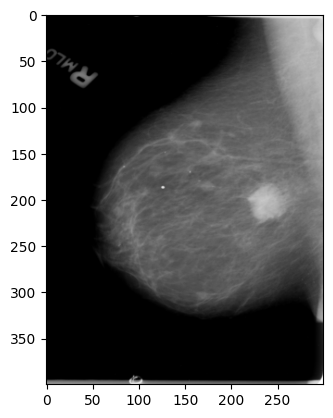

In [4]:
breast = plt.imread('breast2.jpg')
breast = Image.fromarray(breast).resize((300,400), resample=Image.BILINEAR)
plt.imshow(breast, cmap = 'gray')
plt.show()

#### Negative transformation

In [5]:
def neg_trans(img):

  # Get width and height of image
  width,height=img.size

  # Traverse through pixels
  for x in range(width):
    for y in range(height):

      pixel_color=img.getpixel((x,y))

      # s=(L-1)-r
      pixel_color=256-1-pixel_color 

      # Replace the pixel
      img.putpixel((x,y),pixel_color)

  return img

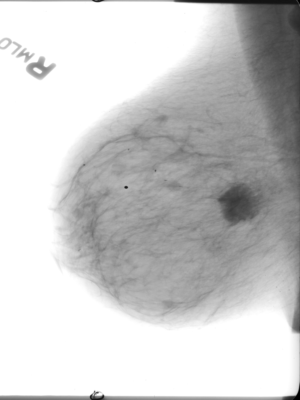

In [6]:
neg_trans(breast)

#### Piecewise transformation

In [11]:
def piece_linear_trans(image, r1, r2, s1, s2):
    image = np.array(image).astype(np.float32)
    img = np.zeros_like(image)

    # Region 1: 0 <= x < r1
    mask1 = image < r1
    img[mask1] = (s1 / r1) * image[mask1]

    # Region 2: r1 <= x <= r2
    mask2 = (image >= r1) & (image <= r2)
    img[mask2] = ((s2 - s1) / (r2 - r1)) * (image[mask2] - r1) + s1

    # Region 3: x > r2
    mask3 = image > r2
    img[mask3] = ((255 - s2) / (255 - r2)) * (image[mask3] - r2) + s2

    # Clip and convert to uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    img_pil = Image.fromarray(img)

    # For plot
    xaxis = list(range(256))
    yaxis = []
    for x in xaxis:
        if x < r1:
            y = (s1 / r1) * x
        elif x <= r2:
            y = ((s2 - s1) / (r2 - r1)) * (x - r1) + s1
        else:
            y = ((255 - s2) / (255 - r2)) * (x - r2) + s2
        yaxis.append(min(max(int(y), 0), 255))

    return img_pil, (xaxis, yaxis)

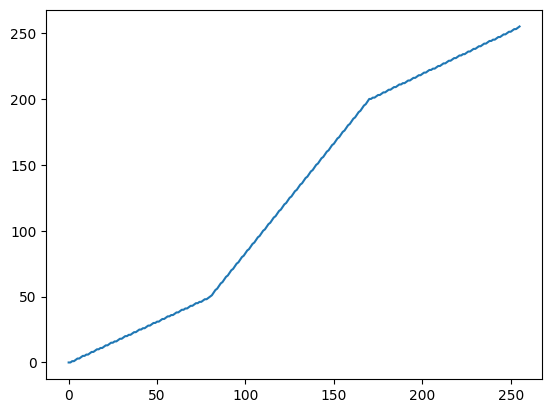

In [14]:
# Define the input range [r1, r2] and output range [s1, s2]
r1 = 80
s1 = 50
r2 = 170
s2 = 200

contrast_stretched, (xaxis, yaxis) = piece_linear_trans(breast, r1, r2, s1, s2)
plt.plot(xaxis, yaxis)

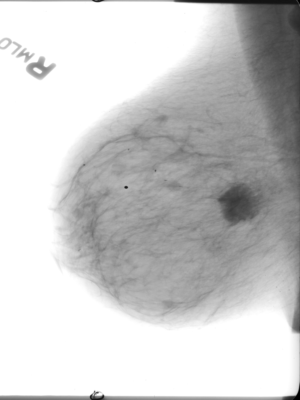

In [15]:
breast

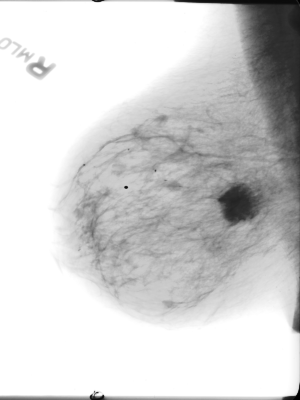

In [13]:
contrast_stretched

## Histogram processing

A technique used to analyze and manipulate the pixel values of an image
based on the distribution of their frequencies in the image. A histogram is a
graphical representation of the frequency distribution of a pixel value in an
image

![figures_intensity/ex_in.png](figures_intensity/ex_hist.png)

### Histogram equalization

Overview: https://www.youtube.com/watch?v=WuVyG4pg9xQ

![figures_intensity/ex_in.png](figures_intensity/hist_eq.png)

where $p(r)$ is normalized histogram such that $\sum p(r) = 1$

#### Application

![figures_intensity/ex_in.png](figures_intensity/ex_hist_eq.png)

N. Erwin, “Improving Retinal Image Quality Using the Contrast Stretching, Histogram Equalization, and CLAHE Methods with Median Filters,” International Journal of Image Graphics and Signal Processing, vol. 12, no. 2, pp. 30–41, Apr. 2020, doi: 10.5815/ijigsp.2020.02.04.

**Histogram Equalization** enhances global contrast by redistributing intensity values across the entire image, which can improve visibility but may over-amplify noise and lead to unnatural results, especially in images with uneven lighting. In contrast, **CLAHE** works locally by dividing the image into smaller regions (tiles) and applying histogram equalization within each, while limiting contrast to avoid noise amplification. This makes CLAHE more effective for enhancing local details and preserving image quality in complex scenarios like medical imaging or low-light environments. While CLAHE is more computationally intensive and requires tuning, it generally produces more natural and detailed results compared to standard histogram equalization.


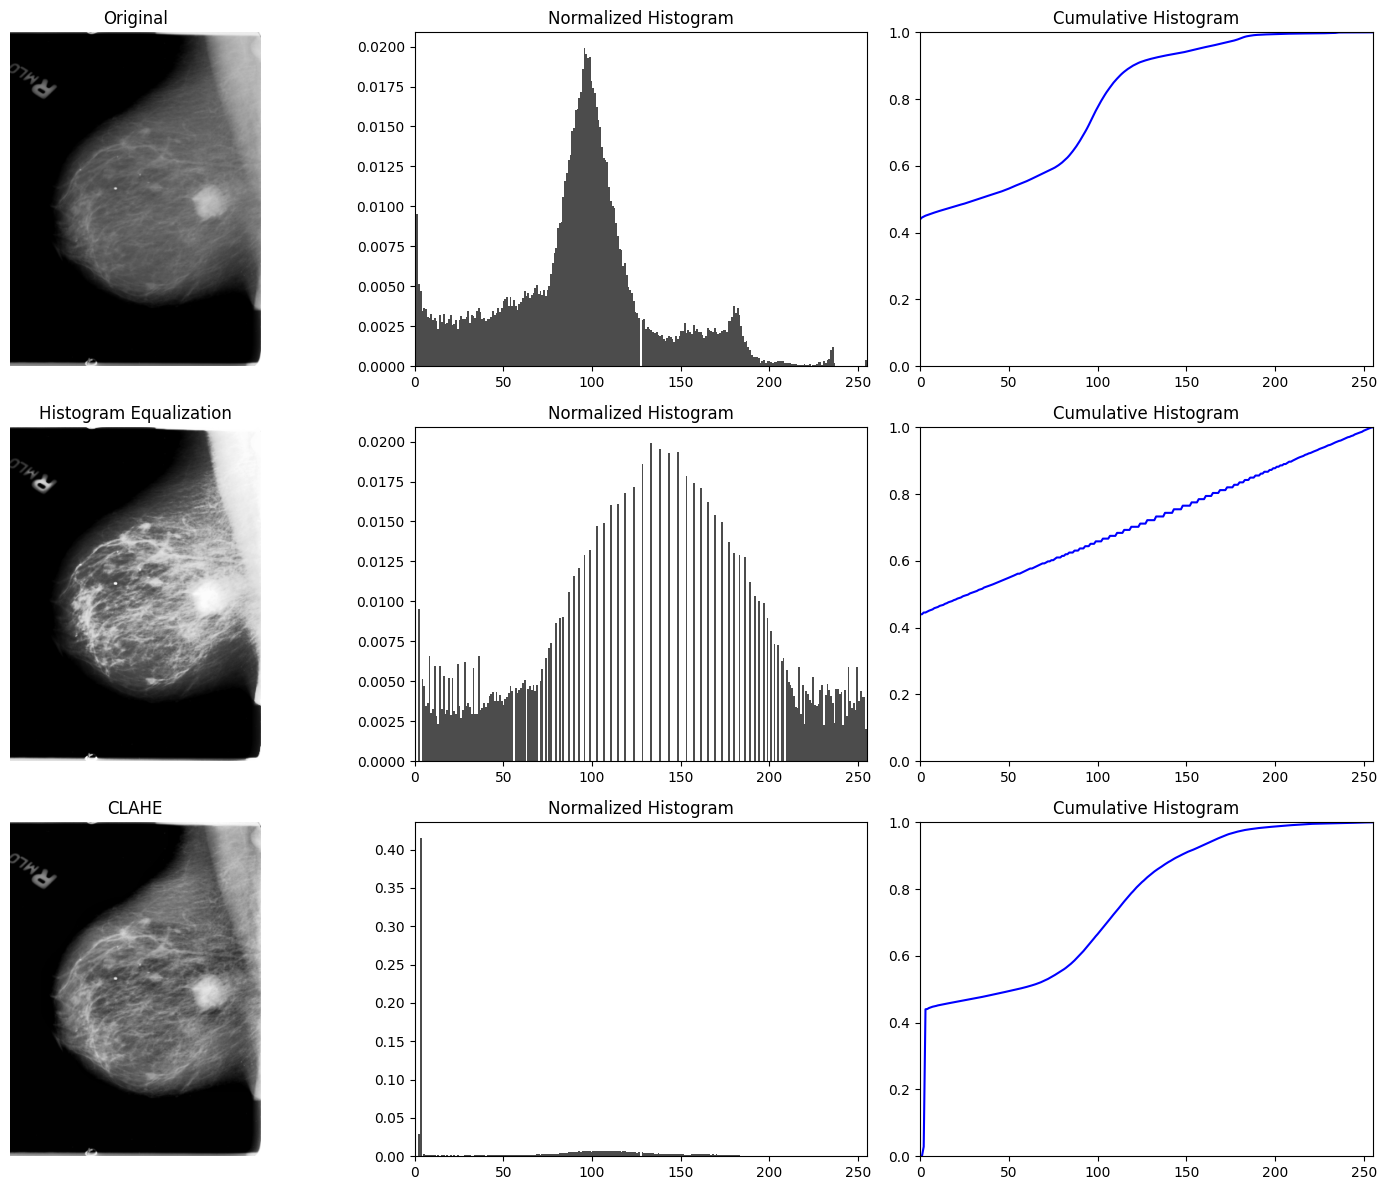

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load and preprocess
breast = plt.imread('breast2.jpg')
breast = Image.fromarray(breast).resize((300, 400), resample=Image.BILINEAR)
breast_gray = breast.convert('L')  # convert to grayscale
img = np.array(breast_gray)

# 1. Histogram Equalization (global)
hist_eq = cv2.equalizeHist(img)

# 2. CLAHE (adaptive)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img)

# Prepare images and titles
images = [img, hist_eq, clahe_img]
titles = ["Original", "Histogram Equalization", "CLAHE"]

# Plot: original + normalized histograms + cumulative histograms
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

for i in range(3):
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 0].set_title(f"{titles[i]}")
    axs[i, 0].axis('off')

    # Mask out pure black pixels for histogram
    masked_img = images[i].ravel()

    axs[i, 1].hist(masked_img, bins=256, color='black', alpha=0.7, density=True,  range=(1, 255))
    axs[i, 1].set_title("Normalized Histogram")
    axs[i, 1].set_xlim([0, 255])


    hist, bins = np.histogram(masked_img, bins=256, range=[0,256], density=True)
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]  # Normalize to 1

    axs[i, 2].plot(bins[:-1], cdf, color='blue')
    axs[i, 2].set_title("Cumulative Histogram")
    axs[i, 2].set_xlim([0, 255])
    axs[i, 2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


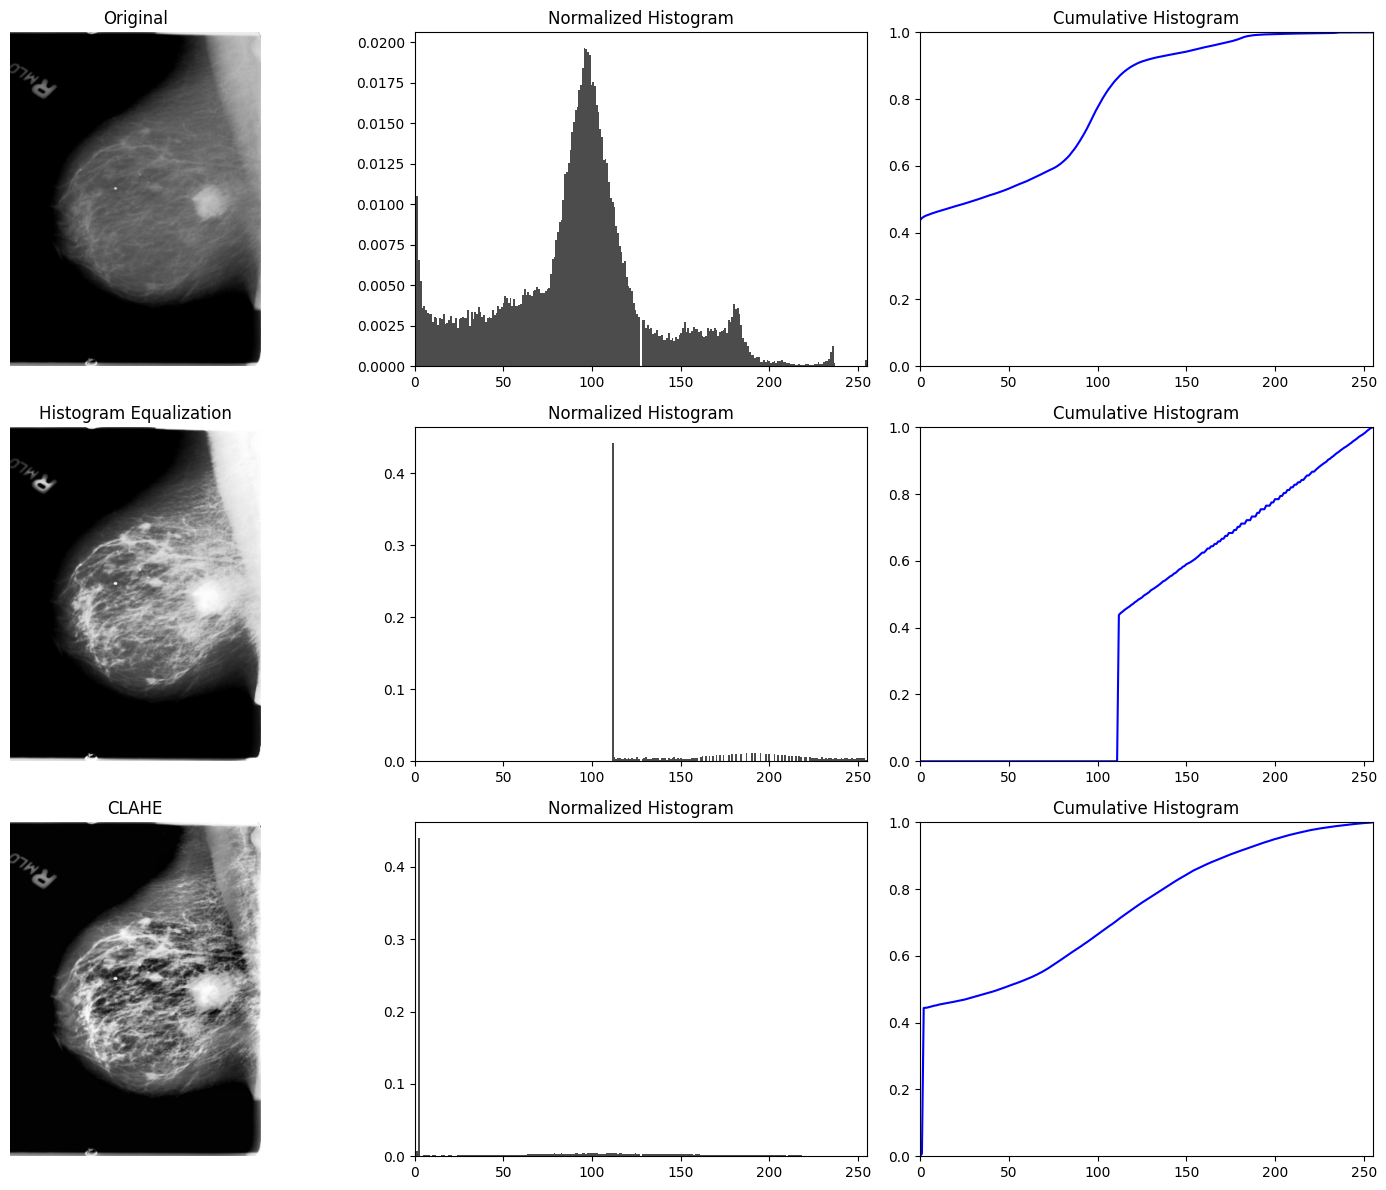

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, transform, img_as_ubyte

# Load and resize
img = io.imread('breast2.jpg')

img_gray = transform.resize(img, (400, 300), anti_aliasing=True)

# Scale to 8-bit unsigned integer
img_gray = img_as_ubyte(img_gray)

# Histogram Equalization
hist_eq = exposure.equalize_hist(img_gray)
hist_eq = img_as_ubyte(hist_eq)

# CLAHE
clahe_img = exposure.equalize_adapthist(img_gray, clip_limit=0.03)
clahe_img = img_as_ubyte(clahe_img)

# Prepare images and titles
images = [img_gray, hist_eq, clahe_img]
titles = ["Original", "Histogram Equalization", "CLAHE"]

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

for i in range(3):
    axs[i, 0].imshow(images[i], cmap='gray')
    axs[i, 0].set_title(titles[i])
    axs[i, 0].axis('off')

    # Mask out pure black pixels for histogram
    masked_img = images[i].ravel()

    # Normalized histogram
    axs[i, 1].hist(masked_img.ravel(), bins=256, range=(1, 255), density=True, color='black', alpha=0.7)
    axs[i, 1].set_title("Normalized Histogram")
    axs[i, 1].set_xlim([0, 255])

    # Cumulative histogram
    hist, bins = np.histogram(masked_img, bins=256, range=(0, 256), density=True)
    cdf = np.cumsum(hist)
    cdf /= cdf[-1]

    axs[i, 2].plot(bins[:-1], cdf, color='blue')
    axs[i, 2].set_title("Cumulative Histogram")
    axs[i, 2].set_xlim([0, 255])
    axs[i, 2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


## Spatial filtering

Spatial filtering modifies an image by replacing the value of each pixel by
a function of the values of the pixel and its neighbors.

spatial domain filtering are based on:

$$g(x,y) = T[f(x,y)]$$

A linear spatial filter performs a sum-of-products operation between an
image and a ***kernel***.

![figures_intensity/ex_in.png](figures_intensity/convolve.png)

***cross-correlation***

$$g(i, j) = ∑∑ f(m, n) · h(i + m, j + n)$$

$$g = f \otimes K$$

Where:

- $g(i, j)$ is the output (cross-correlation) at position $(i, j)$

- $f(m, n)$ is the input matrix (e.g., an image)

- $h(i + m, j + n)$ is the kernel shifted over the input

***convolution***

$$g(i, j) = ∑∑ f(m, n) · h(i - m, j - n)$$

$$g = f * K$$

Where:

- $g(i, j)$ is the output at position $(i, j)$

- $f(m, n)$ is the input matrix (e.g., an image)

- $h(i - m, j - n)$ is the kernel shifted over the input


Other terms used to refer ***kernel*** are filter, mask, windows and impulse response function.

***Animation***: https://www.youtube.com/watch?v=O9-HN-yzsFQ

NOTE

- In deep learning, “convolution” operation is actually cross-correlation.
- In DL, we don’t usually care about flipping the kernel because the weight
is being tuned.
- Cross-correlation is easier to implement

#### Linear Spatial filtering example: Low pass filter (Moving average filter, box kernel)

Replace each pixel by weighted average of its neighbors

![filter_mv.png](figures_intensity/filter_mv.png)

#### Linear Spatial filtering example: Low pass filter (Gaussian kernel)

Replace each pixel by weighted average of its neighbors

![filter_mv.png](figures_intensity/filter_gaussian.png)

#### NonLinear Spatial filtering example: Low pass filter

Replace each pixel by weighted average of its neighbors

![filter_mv.png](figures_intensity/filter_nonlinear.png)

- Median Filter – Median Pixel (green):
    Median filtering is a non-linear filter that replaces each pixel with the median value of the neighboring pixels in a window (e.g., 3×3).

    - This method is especially good at removing salt-and-pepper noise (i.e., random black and white pixels).


- α-Trimmed Mean Filter: An α-trimmed mean filter is a hybrid between mean and median filters:

    - It sorts the pixel values in the neighborhood. Then discards α% of the smallest and largest values. Finally, it averages the remaining values.


# Frequency domain filtering

## Concept

https://www.youtube.com/watch?v=spUNpyF58BY

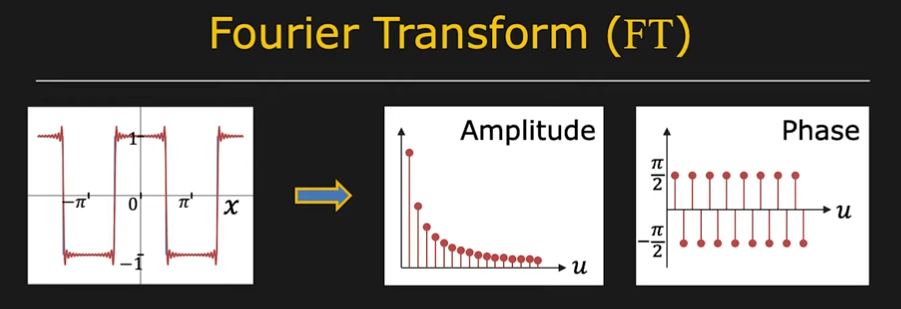

Time domain   ->    frequency domain

## Why fourier transform

- Provide insights, what is mean to be "smoothing image", "edge in the image".
- Computational efficient (multiplication in frequency domain is convolution in spatial domain)
- Alternative data representation or alternative recording.

## Fourier series

Function f(t) that is a periodic function with period $T$ can be written in the form of summation of sines and cosines functions multipled by a cofficient.

$$f(t) = \frac{a_0}{2} + \sum^∞_{n= 0}( a_n cos(\frac{2πn}{T}t) + b_n sin(\frac{2πn}{T}t) )$$

with some algebratic manipulation using Euler's formula ($e^{iθ} = \text{cos}θ + i\text{sin}(θ)$)


> $$f(t) =\sum^∞_{n= -∞} c_n e^{i2πnt/T} $$




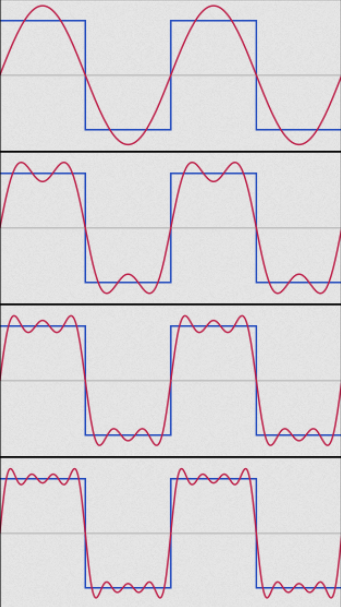

https://en.wikipedia.org/wiki/Fourier_series

We want to find cofficient of complex exponential $c_n$. Because $e^{i2πnt/T}$ and $e^{-i2πmt/T}$ are orthogonal to each other when $n \neq m$. We can find $c_n$ by

> $$c_n = \frac{1}{T} \int^{T/2}_{-T/2} f(t)e^{-i2πnt/T} dt \tag{*}$$

**Further reading**

https://www.youtube.com/watch?v=UKHBWzoOKsY



## Fourier transform



When f(t) is not a periodic function, we can use fourier transform. Denote that fourier transform ($\mathcal{F}$) of $f(t)$ can be written by
$$\mathcal{F}(f(t)) = F(μ)$$.

and inverted fourier transform can be written by

$$\mathcal{F}^{-1}(F(μ)) = f(t)$$

Relation to fourier series

$$f(t) = \sum^∞_{n= -∞} c_n e^{i2πnt/T}$$

we can find fourier series of $f(t)$ ($f(t)$ can be non-periodic function) by let $T → ∞$

> $$\text{lim}_{T → ∞} f(t) = ∫^{∞}_{-∞} F(μ) e^{j2πμt} dμ \tag{1}$$

Then we can find $F(μ)$ by using orthogonal property of $e^{j2πμt}$.

> $$F(μ) = ∫^{∞}_{-∞} f(t)e^{-j2πμt} dt \tag{2}$$

Equation (1) and (2) are related to each other which called Fourier transform pair, denote as $f(t) ⇔ F(μ)$.  The double arrow indicates that the expression on the right is obtained by taking the forward Fourier transform of the expression on the left, while the expression on the left is obtained by taking the inverse Fourier transform of the expression on the right.

## Fourier transform property $f(t) ⇔ F(\mu)$

https://en.wikipedia.org/wiki/Fourier_transform#Basic_properties

## Discrete fourier transform
In practice, we have discrete function instead of continuous function. Let see what happen in frequency domain after we sampling the continuous signal.

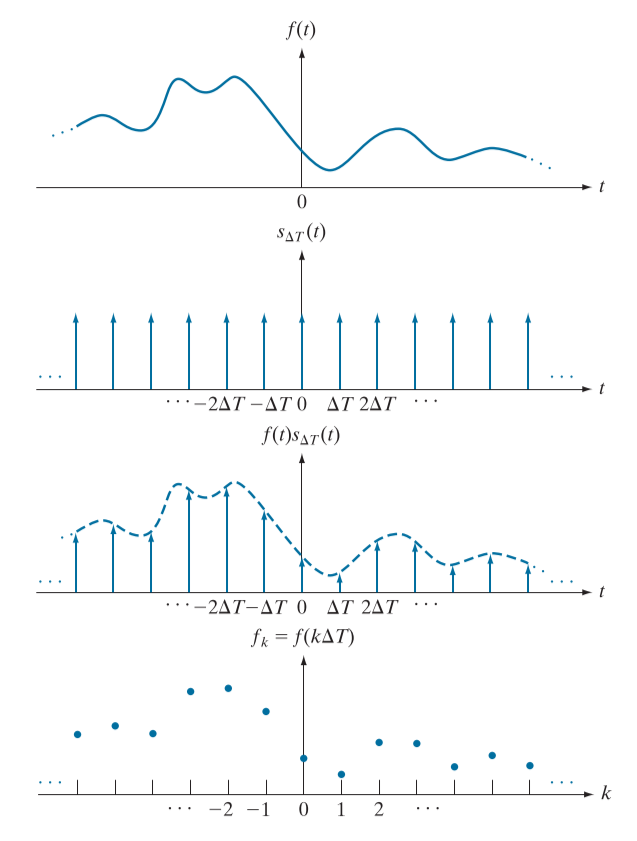




### Sampling and aliasing

**Convolution animation**

https://phiresky.github.io/convolution-demo/

https://github.com/phiresky/convolution-demo

### Nyquist rate
The theoretical minimum sampling rate at which a signal can be sampled and still can be reconstructed from its samples without any distortion is called the Nyquist rate

$$f_N > 2f_{max}$$

for $f_N$ is Nyquist rate and $f_{max}$ is the maximum frequency present in that signal.

**Proof why impulse train on time domain is impulse train on frequency domain**

We can convert continuous function into sequence of discrete values by sampling and quantization. For a continuous function $f(t)$ we sampling at uniform intervals, $T$, we can sampling the function by multiply the function to train of discrete impulse $p(t)$.

$$f'(t) = f(t)×p(t)$$

for

$$p(t) = ∑^∞_{n = -∞} δ(t-nT)$$

because $p(t)$ is periodic function we can write the above equation in fourier series

$$p(t) = ∑^∞_{n = -∞} p_k e^{i2πnt/T}$$

for

$$p_k = \frac{1}{T}∫^{T/2}_{t = -T/2}  δ(t) e^{-j2πkt/T} dt = \frac{1}{T}$$

Then we find fourier transform, $\mathcal{F}(p(t)) = P(μ)$

$$P(μ) = \mathcal{F}(\frac{1}{T}∑^∞_{n = -∞} e^{i2πnt/T}) = \frac{1}{T} ∑^∞_{n = -∞} δ(μ - \frac{n}{T})$$


### Discrete fourier

let $F'(\mu)$ be a fourier transform of the sampling function $f'(t)$

$$F'(\mu) = \mathcal{F}(f'(t)) = \mathcal{F}( f(t)×p(t))$$
$$F'(\mu) = ∫^∞_{-∞} ∑^∞_{n = -∞} f(t) δ(t-nT) e^{-i2πμt} dt$$
$$F'(\mu) = ∑^∞_{n = -∞} f(nT) e^{-i2πμnT} $$

Because we know that $F'(μ)$ is periodic ($F'(μ) = F'(μ + 1/T)$), we write $ω = 2πμT$, we got

> $$F'(ω) = ∑^∞_{n = -∞} f[n] e^{-iω n} \tag{3}, ω ∈ [0, 2π )$$


The equation (3) is call discrete time fourier transform (DTFT).

In computer, we want to obtain $M$ equally spaced samples of $F'(μ)$ taken over $μ ∈ [0, 1/T)$, we set $μ = \frac{m}{MT}$, we got

$$F_m = ∑^∞_{n = -∞} f[n] e^{-i2πnm/M}$$

> $$F_m = ∑^{M-1}_{n = 0} f[n] e^{-i2πnm/M} \tag{4}, m = 0,1,2,...,M-1$$

The equation (4) is call discrete fourier transform (DFT). You can view DFT as the sample of DTFT.

## Summary

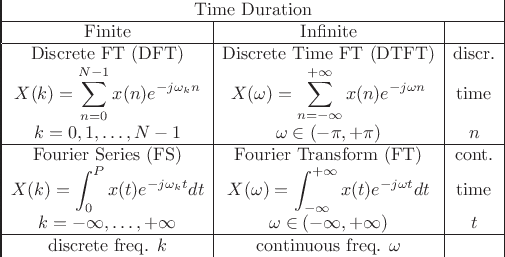

## Fast fourier transform

DFT is not practical because its computational time. In practice we use fast fourier transform (FFT) instead.

## 2D fourier transform

2D DFT is written below

$$F[u,v] = ∑_{x=0}^{N-1} ∑_{y=0}^{M-1} f[x, y] e^{-j2πux/N} e^{-j2πvy/M}$$

Further study

https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

## Coding fourier transform

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
freq = np.fft.fftfreq(10, d = 1/400)
freq = np.fft.fftshift(freq)
freq

array([-200., -160., -120.,  -80.,  -40.,    0.,   40.,   80.,  120.,
        160.])

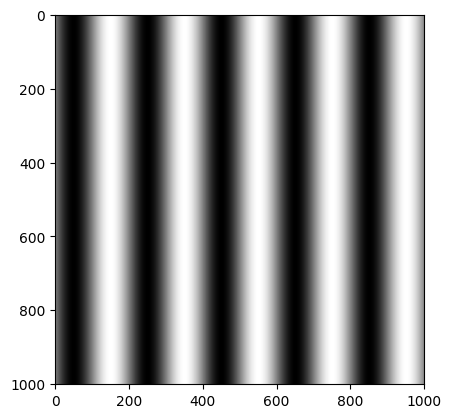

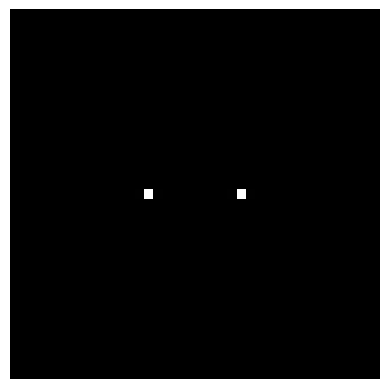

In [6]:


x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
grating = np.sin(2 * np.pi * X / wavelength)
plt.set_cmap("gray")
plt.imshow(grating)
plt.show()

# freq = np.fft.fftfreq(len(x), d = 1/400)
# freq = np.fft.fftshift(freq)

ft = np.fft.fft2(grating)
ft = np.fft.fftshift(ft)

plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis('off')
plt.show()

# Note that the plot below we ignore the phase information

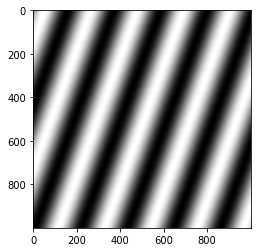

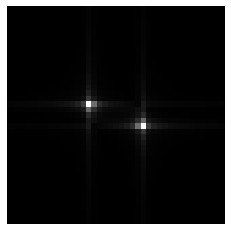

In [ ]:
x = np.arange(0,1000, 1)
X, Y = np.meshgrid(x, x)
wavelength = 200
angle = np.pi / 9
grating = np.sin(
    2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength
)
plt.set_cmap("gray")
plt.imshow(grating)
plt.show()


ft = np.fft.fft2(grating)
ft = np.fft.fftshift(ft)

plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])
plt.axis('off')
plt.show()

## Coding inverted fourier transform

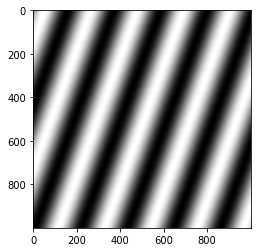

In [ ]:

ift = np.fft.ifftshift(ft)
ift = np.fft.ifft2(ift)

plt.imshow(ift.real)

plt.show()

## Note amplitude vs phase

- View amplitude as relative prominence of sinusoids
- View phase as relative displacement of sinusoids

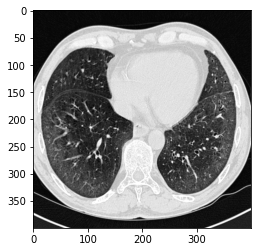

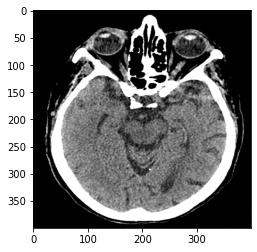

In [ ]:
ct_chest = cv2.imread('data/ct_chest.jpg')
ct_chest = cv2.cvtColor(ct_chest, cv2.COLOR_BGR2GRAY)
ct_chest = cv2.resize(ct_chest, (400,400), interpolation = cv2.INTER_CUBIC)

ct_brain = cv2.imread('data/ct.jpeg')
ct_brain = cv2.cvtColor(ct_brain, cv2.COLOR_BGR2GRAY)
ct_brain = cv2.resize(ct_brain, (400,400), interpolation = cv2.INTER_CUBIC)


plt.imshow(ct_chest, cmap = 'gray')
plt.show()

plt.imshow(ct_brain, cmap = 'gray')
plt.show()

# calculate fft from ct chest
ft = np.fft.fft2(ct_chest)
ft = np.fft.fftshift(ft)

# get amplitude and phase for ct chest
amp_ct_chest = abs(ft)
phase_ct_chest = ft/amp_ct_chest

# calculate fft from ct brain
ft = np.fft.fft2(ct_brain)
ft = np.fft.fftshift(ft)

# get amplitude and phase from ct brain
amp_ct_brain = abs(ft)
phase_ct_brain = ft/amp_ct_brain

### inverted fourier only amplitude

<ipython-input-43-73862382bc09>:4: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(ift.real))


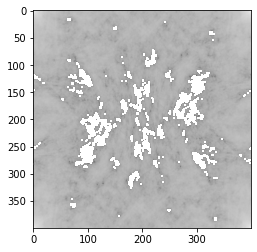

In [ ]:
ift = np.fft.ifftshift(amp_ct_brain)
ift = np.fft.ifft2(ift)

plt.imshow(np.log(ift.real))

plt.show()

### inverted fourier only phase

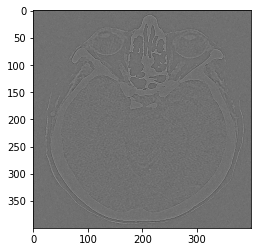

In [ ]:
ift = np.fft.ifftshift(phase_ct_brain)
ift = np.fft.ifft2(ift)

plt.imshow(ift.real)

plt.show()

### using phase and amplitude from different pictures

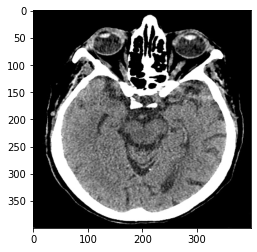

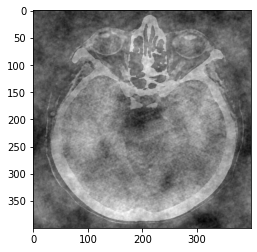

In [ ]:
ift = np.fft.ifftshift(phase_ct_brain*amp_ct_brain)
ift = np.fft.ifft2(ift)

plt.imshow(ift.real)

plt.show()

ift = np.fft.ifftshift(phase_ct_brain*amp_ct_chest)
ift = np.fft.ifft2(ift)

plt.imshow(ift.real)

plt.show()

## Applications

### Filtering in frequency domain

Filtering in frequency domain is more inutitive than filtering in spatial domain.

$$f'(t) = \text{Real} [ \mathcal{F}^{-1}(F(u,v)H(u,v))]$$

where $F(u, v)$ is DFT of the input image $f(t)$, $H(u,v)$ is a filter transfer function and $f'(t)$ is filtered image.

#### Lowpass filter

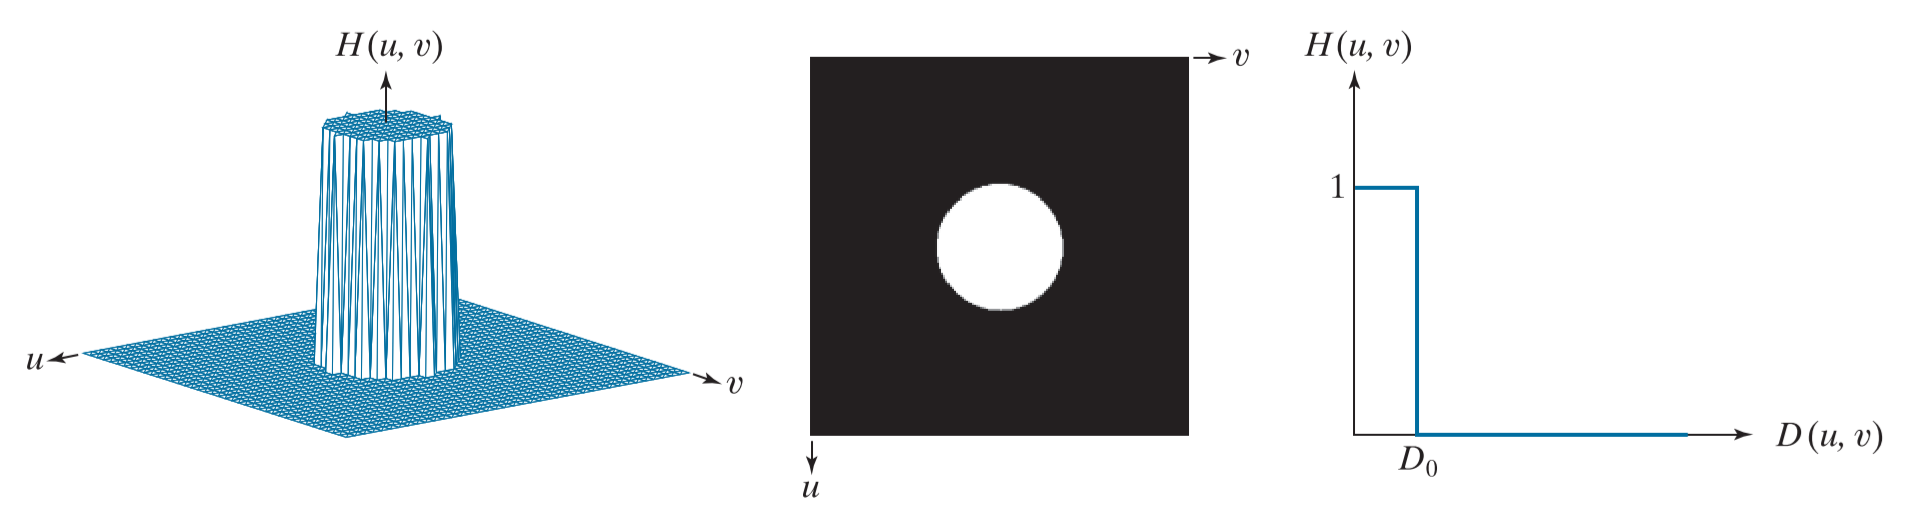

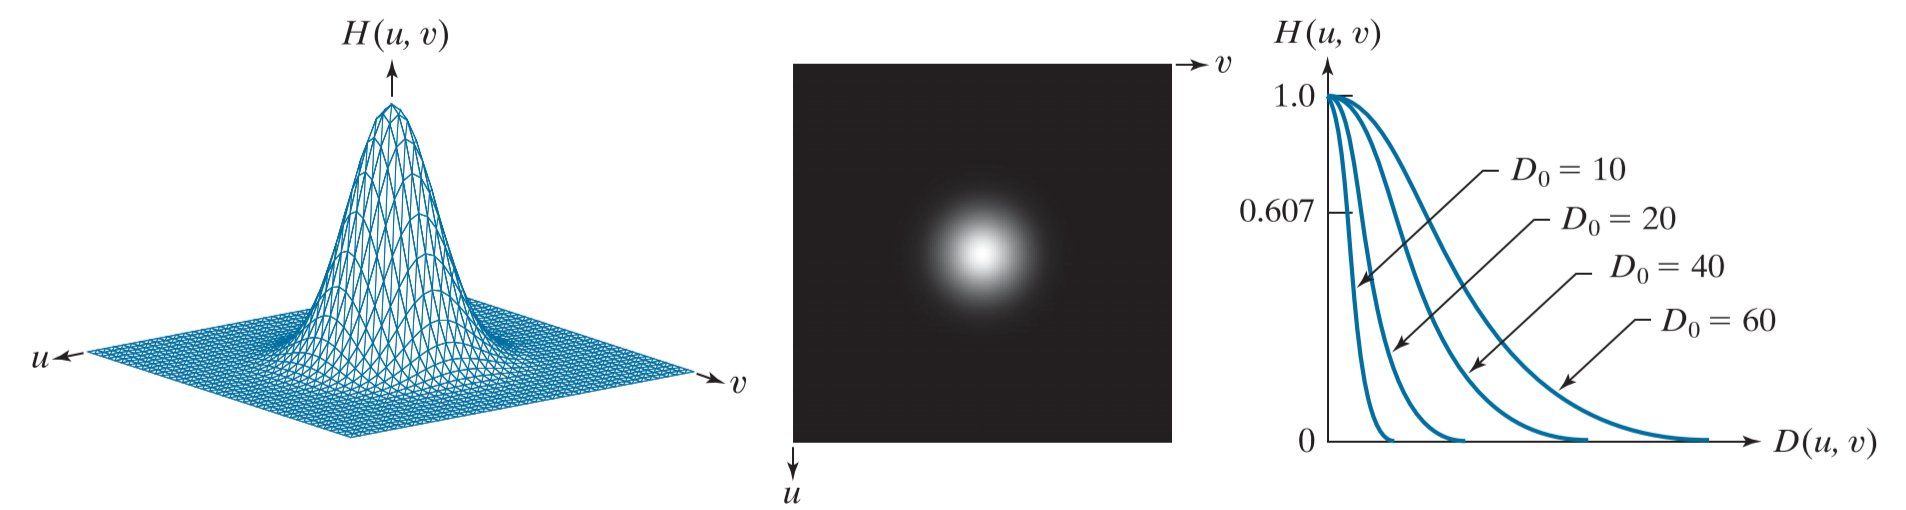

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussian_lowpass(d0,img_shape):
    base = np.zeros(img_shape[:2])
    rows, cols = img_shape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(d0**2))))
    return base

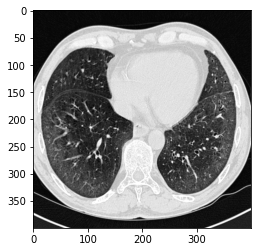

In [ ]:
ct_chest = cv2.imread('data/ct_chest.jpg')
ct_chest = cv2.cvtColor(ct_chest, cv2.COLOR_BGR2GRAY)
ct_chest = cv2.resize(ct_chest, (400,400), interpolation = cv2.INTER_CUBIC)

plt.imshow(ct_chest, cmap = 'gray')
plt.show()

# calculate fft from ct chest
ft = np.fft.fft2(ct_chest)
ft = np.fft.fftshift(ft)

# get amplitude and phase for ct chest
amp_ct_chest = abs(ft)
phase_ct_chest = ft/amp_ct_chest


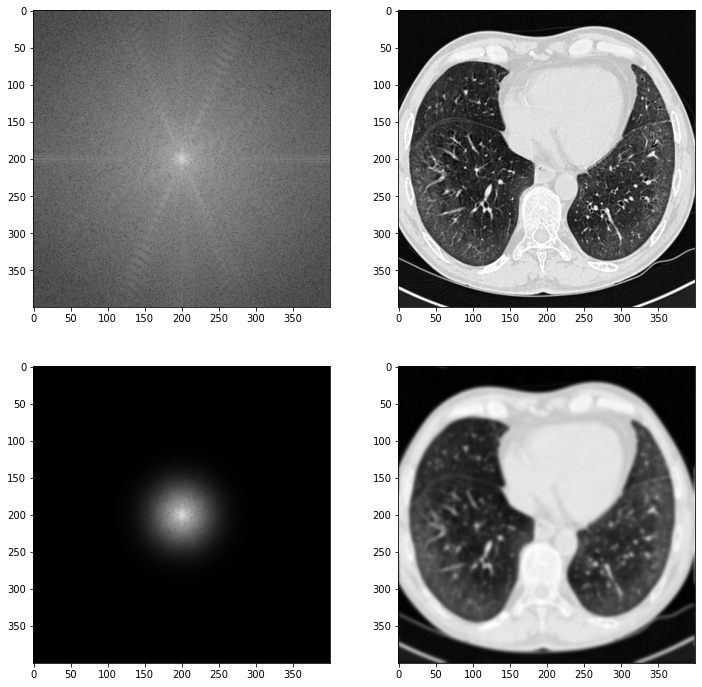

In [ ]:
lp_filter = gaussian_lowpass(30, amp_ct_chest.shape)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(np.log(amp_ct_chest), cmap = 'gray')


plt.subplot(2, 2, 2)
plt.imshow(ct_chest, cmap = 'gray')


plt.subplot(2, 2, 3)
plt.imshow(np.log(amp_ct_chest)*(lp_filter), cmap = 'gray')


plt.subplot(2, 2, 4)
ift = np.fft.ifftshift(phase_ct_chest*amp_ct_chest*lp_filter)
ift = np.fft.ifft2(ift)
plt.imshow(ift.real, cmap = 'gray')
plt.show()


#### Highpass filter

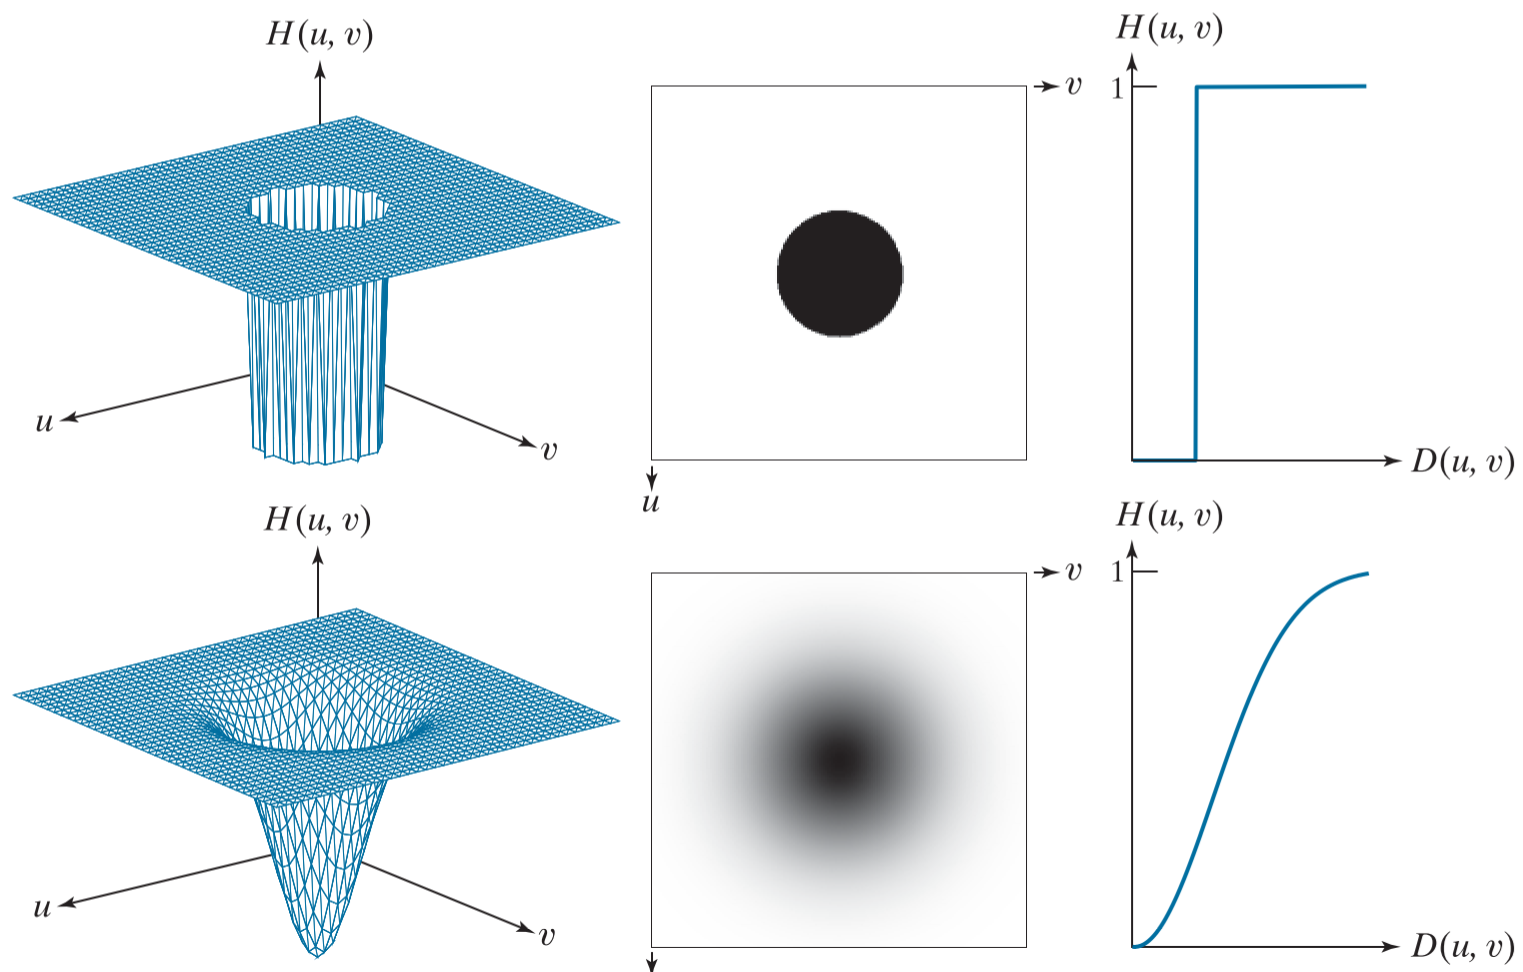

#### Notch filter

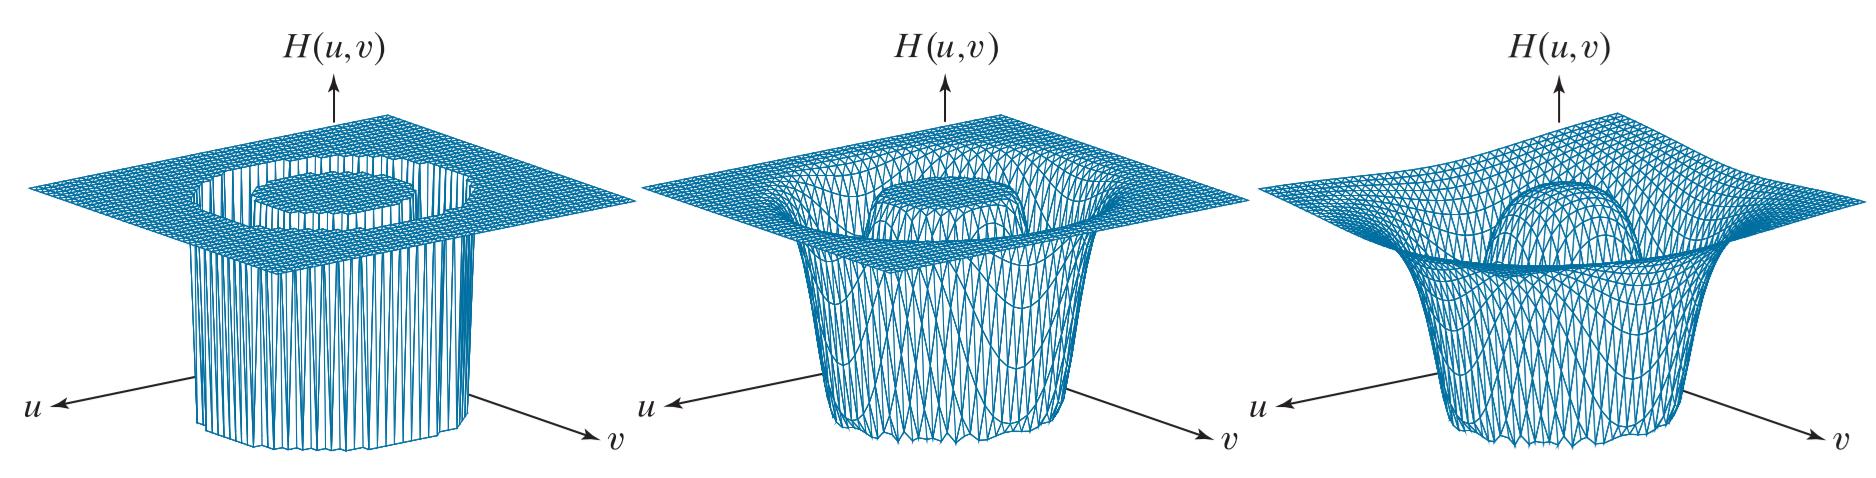

### CT image reconstruction (Radon transform)


https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

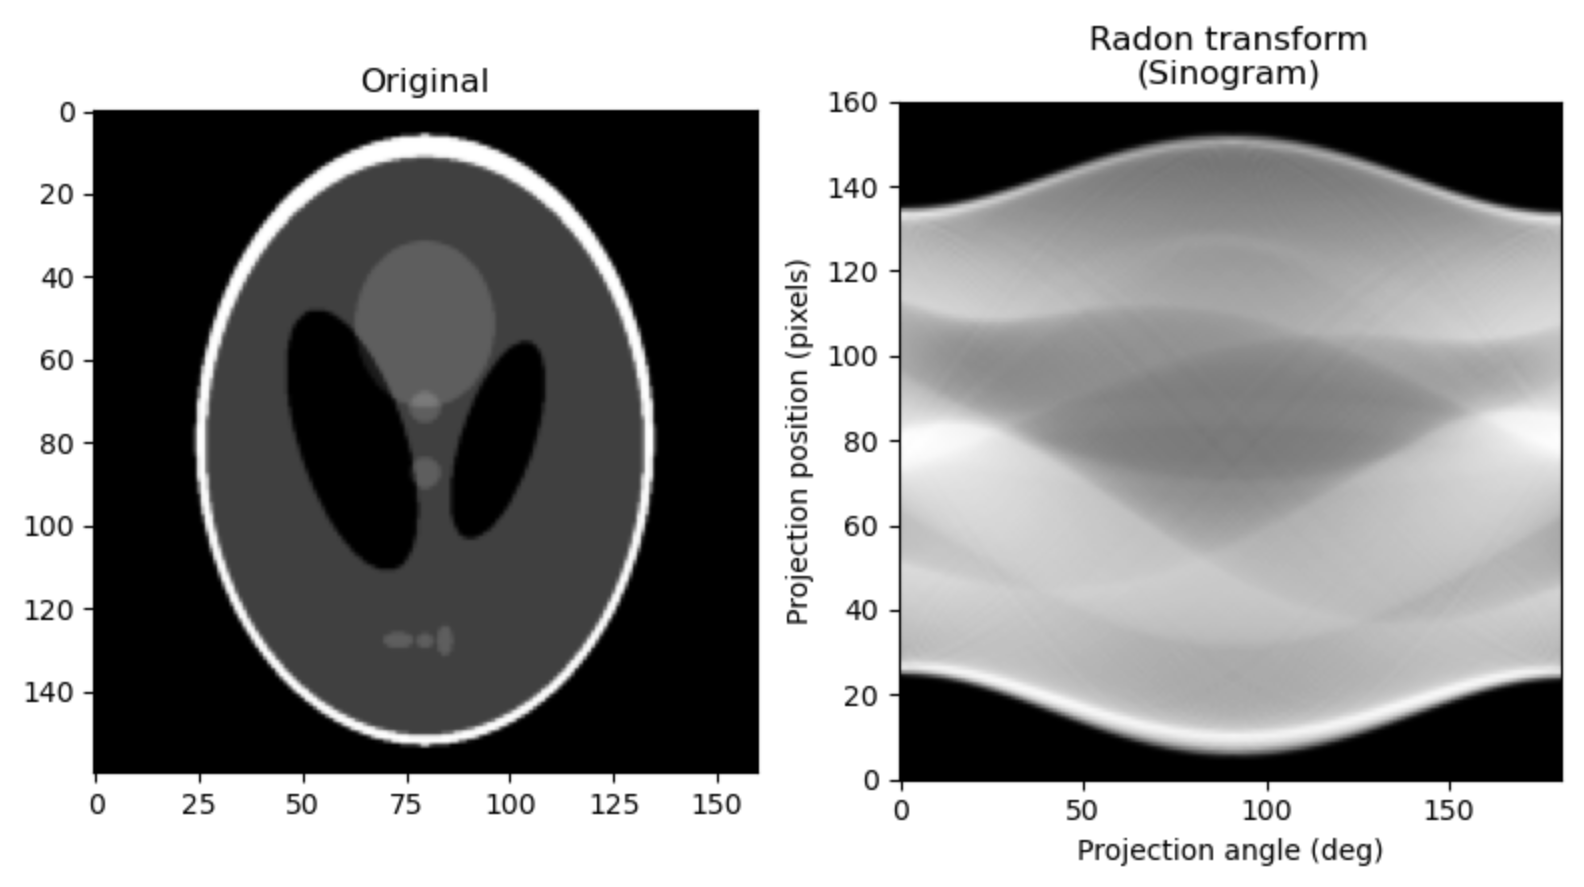

Detector at position $x'$ get the radiation from the line that travel along the object. All the point on that line must be satified the equation

#### Radon transform

$$x' = xsinθ - ycosθ $$

$$R (x', θ) = ∫∫_{x' = xsinθ - ycosθ} f(x,y) dxdy$$
$$R (x', θ) = ∫∫ f(x,y) δ [x'-(xsinθ - ycosθ)] dxdy$$

Fourier transform on pixel projection.

$$R (z, θ) = ∫∫ f(x,y) ∫δ [x'-(xsinθ - ycosθ)] e^{-j2π z x'} dxdy$$

$$R (z, θ) = ∫∫ f(r,ϕ)  e^{-j2π z (rcos ϕ sinθ - rsin ϕ cosθ)} rdrdϕ$$

View $z sin θ = u $, $-zcosθ = v$

$$R (u, v) = ∫∫ f(r,ϕ)  e^{-j2π (urcos ϕ +vrsin ϕ )} rdrdϕ$$

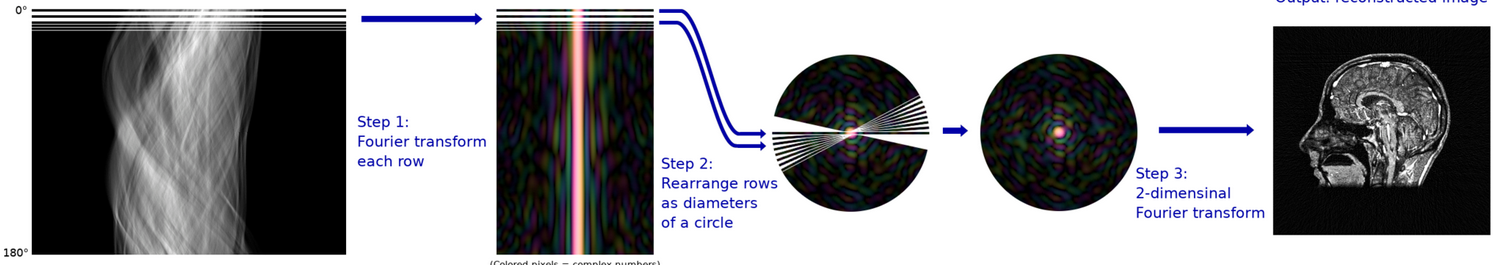

#### Fourier transform

$$A(u,v) = \int \int f(x, y) e^{-j2π(ux+vy)} dxdy $$

$$A(u,v) = \int \int f(r, ϕ) e^{-j2π(urcos(ϕ)+vrsin(ϕ))} rdr dϕ $$

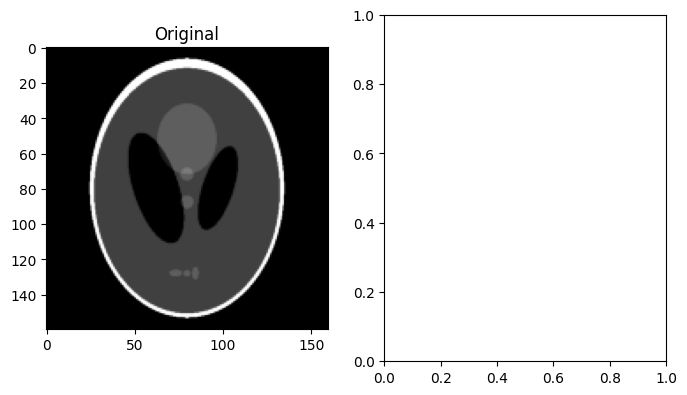

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)
plt.show()


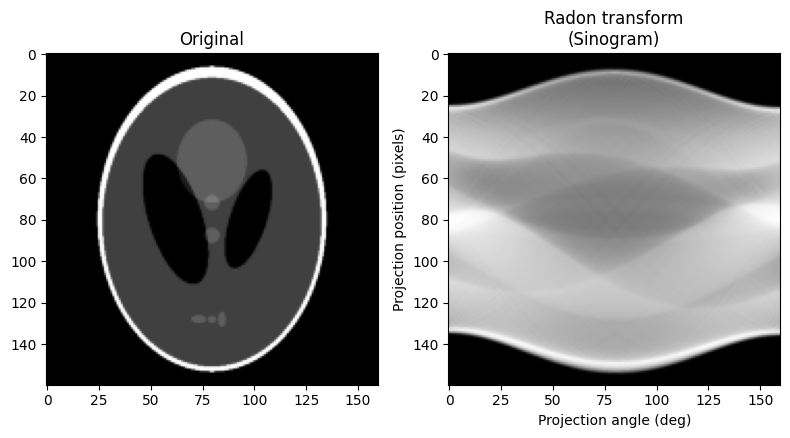

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0283


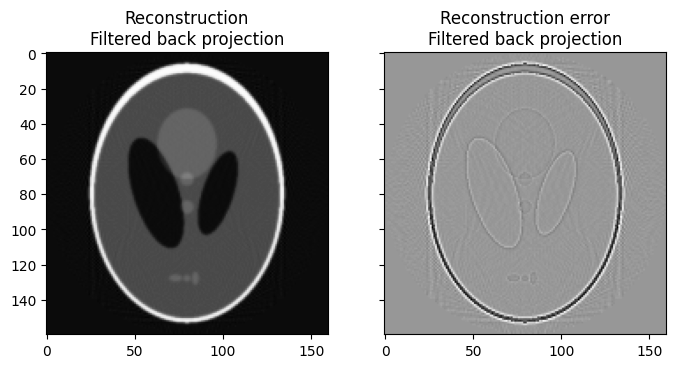

In [ ]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r)
plt.show()

## Other Application

### Neuroscience

https://www.researchgate.net/figure/The-brain-waves-of-a-typical-child-versus-an-autistic-child-were-measured-using-EEG-at_fig1_221914660

https://www.youtube.com/watch?v=FIqvTUOGFOE

Astronomy

https://www.youtube.com/watch?v=nFEgRt2EH1g